# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [1]:
# Initial import
import dcgpy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline

### Data set

In [66]:
# We import the data for a classification task
from numpy import genfromtxt
# https://archive.ics.uci.edu/ml/datasets/Abalone
my_data = genfromtxt('abalone_data_set.csv', delimiter=',')
points = my_data[:,:-1]
labels_tmp = my_data[:,-1]
# We trasform the categorical variables to one hot encoding
labels = np.zeros((len(labels_tmp), 29))
for i,l in enumerate(labels_tmp):
    labels[i][int(l)-1] = 1
# We shuffle the dataset
points, labels = shuffle(points, labels, random_state=0)
# And create training and test set
X_train = points[:3000]
Y_train = labels[:3000]
X_test = points[3000:]
Y_test = labels[3000:]


In [65]:
len(labels)

4177

### Mutating a dCGPANN

Starting error: 3.3626867701938807
Net complexity (number of active weights): 1980
Net complexity (number of unique active weights): 1980
Net complexity (number of active nodes): 107


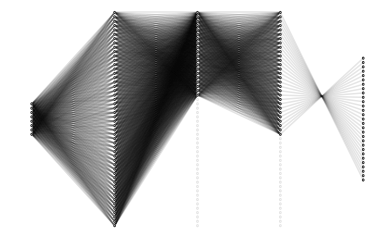

In [100]:
# We define a single input single output dCGPANN.
dcgpann = dcgpy.encode_ffnn(8,29,[50,20],["sig", "sig", "ReLu"], 5)

# By default all weights (and biases) are set to 1 (and 0). We initialize the weights normally distributed
dcgpann.randomise_weights(mean = 0., std = 0.1)
dcgpann.randomise_biases(mean = 0., std = 0.1)


# Since the output is a probability we use sigmoids for all output nodes.
dcgpann.set_output_f(0)

print("Starting error:", dcgpann.loss(X_test,Y_test, "CE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))

dcgpann.visualize()

Start error (training set): 2.7556408390458493
Start error (test): 2.8438363424834683


100%|██████████| 100/100 [00:04<00:00, 21.22it/s]


End error (training set): 2.7190309608341106
End error (test): 2.808315143075998


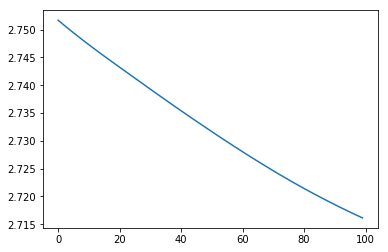

In [102]:
res = []

# We train
n_epochs = 100
print("Start error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("Start error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)

for i in tqdm(range(n_epochs)):
    res.append(dcgpann.sgd(X_train, Y_train, 0.3, 128, "CE"))

print("End error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("End error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)
xt = dcgpann.get()
wt = dcgpann.get_weights()
bt = dcgpann.get_biases()

plt.plot(res)

100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


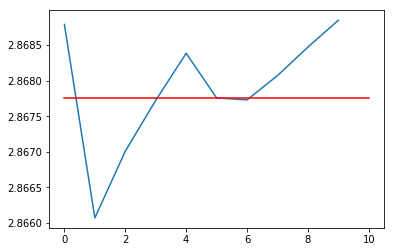

In [23]:
# We show the effect of trained mutations
n_mutations = 10
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(1)
    for i in range(n_epochs):
        dcgpann.sgd(X_train, Y_train, 0.1, 32, "CE")
    mut.append(dcgpann.loss(X_test,Y_test, "CE"))

dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in range(n_epochs):
        dcgpann.sgd(X_train, Y_train, 0.1, 32, "CE")


_ = plt.plot(mut)
_ = plt.plot([0,n_mutations],[dcgpann.loss(X_test,Y_test, "CE"),dcgpann.loss(X_test,Y_test, "CE")],'r')

In [29]:
X_train[0]

array([0.    , 0.55  , 0.425 , 0.155 , 0.9175, 0.2775, 0.243 , 0.335 ])

In [30]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [31]:
dcgpann(X_train[0])

[0.31843792281464545,
 0.0,
 0.0,
 0.06130183040517015,
 0.08357119338510016,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06130183040517015,
 0.0,
 0.0,
 0.0,
 0.0724054569488587,
 0.0,
 0.0,
 0.05728193076478739,
 0.0,
 0.015731054402864996,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01974332550982736,
 0.01974332550982736,
 0.08357119338510016,
 0.05091077893970851,
 0.0,
 0.0]

In [105]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# We define Stochastic Gradient Descent as an optimizer
sgd = optimizers.SGD(lr=0.3)
# We define weight initializetion
initializerw = keras.initializers.RandomNormal(mean=0.0, stddev=1.1, seed=None)
initializerb = keras.initializers.RandomNormal(mean=0.0, stddev=1.1, seed=None)

model = Sequential([
    Dense(50, input_dim=8, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(29, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('softmax'),
])
model.compile(optimizer=sgd,
              loss='categorical_crossentropy')
history = model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=False)

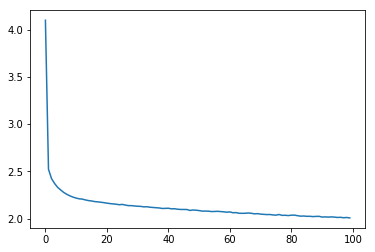

In [106]:
plt.plot(history.history['loss'])